# 5.1 Evaluating generative text models

## 5.1.1 Using GPT to generate text

In [2]:
# Import code from last chapter and initialize a GPT model
import torch
from previous_chapters import GPTModel
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256, 
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [3]:
# Utility functions for text to token ID conversion
import tiktoken
from previous_chapters import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [4]:
# Test the two above functions
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


## 5.1.2 Calculating the text generation loss

In [5]:
# Input examples
inputs = torch.tensor([[16833, 3626, 6100], # every effort moves
                       [40,    1107, 588]]) # I really like
targets = torch.tensor([[3626, 6100, 345  ], # effort moves you
                        [1107,  588, 11311]]) # really like chocolate

In [6]:
# Get probas
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [7]:
# Obtain corresponding token IDs
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [8]:
# Converts the token IDs back into text
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [9]:
# Print the initial softmax probability scores
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [10]:
# Applying the logarithm to the probability scores
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [11]:
# Combine the log probabilities into a single score by averaging
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [12]:
# Calculate the negative average log probability
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


In [13]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

Logits shape: torch.Size([2, 3, 50257])


In [14]:
# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Targets shape: torch.Size([2, 3])


In [15]:
# Flatten the tensors by combining them over the batch dimension
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [16]:
# Calculate loss with cross_entropy function
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


In [17]:
# Calculate the perplexity
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


## 5.1.3 Calculating the training and validation set losses
I am using "The Pit and the Pendulum" by Edgar Allan Poe (which is in the public domain) for text preprocessing to get some novel results.

In [18]:
# Loads the short story
file_path = "pit-and-pendulum.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [19]:
# Check the number of characters and tokens
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 33679
Tokens: 7702


In [20]:
# Define training and validation split
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [21]:
# Create train and val data loader
from previous_chapters import create_dataloader_v1
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [22]:
# Sanity check
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")
    
if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [23]:
# Check they were created correctly
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
    
print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([1, 256]) torch.Size([1, 256])


In [24]:
# Another Sanity Check
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 6656
Validation tokens: 768
All tokens: 7424


In [25]:
# A utility function for cross entropy loss
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

In [26]:
# Function to compute the training and validation loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [27]:
# Apply the loader to the training and validation set loaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) 
torch.manual_seed(123)
with torch.no_grad(): 
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.993525651785044
Validation loss: 11.013991355895996


# 5.2 Training an LLM

In [28]:
# Helper functions for monitoring steps
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [29]:
# The main function for pretraining LLMs
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1} (Step {global_step:06d}): Train Loss {train_loss:.3f}, Val Loss {val_loss:.3f}")
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

In [30]:
# Train a GPTModel instance for 10 epochs
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="So far, I had", tokenizer=tokenizer)

Epoch 1 (Step 000000): Train Loss 9.603, Val Loss 9.932
Epoch 1 (Step 000005): Train Loss 8.113, Val Loss 8.447
Epoch 1 (Step 000010): Train Loss 6.918, Val Loss 7.510
So far, I had the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Epoch 2 (Step 000015): Train Loss 6.336, Val Loss 7.217
Epoch 2 (Step 000020): Train Loss 6.139, Val Loss 7.174
Epoch 2 (Step 000025): Train Loss 5.907, Val Loss 7.194
So far, I had, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and
Epoch 3 (Step 000030): Train Loss 6.027, Val Loss 7.232
Epoch 3 (Step 000035): Train Loss 5.819, Val Loss 7.233
So far, I had, and the, and the, and, and the, and the, and the, and, and the, and, and the, and the, and the, and, and the, and, and, and, and the. I,
Epoch 4 (Step 000040): Train Loss 5.804, Val Lo

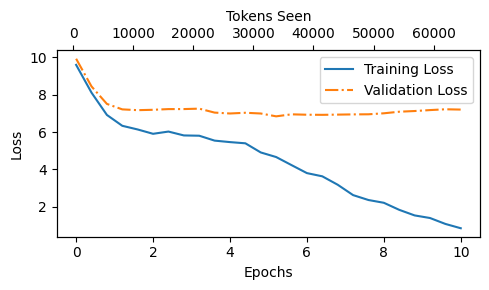

In [31]:
# Visualizing the training and validation set losses
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen.tolist(), train_losses, label="Training Loss")
    ax1.plot(epochs_seen.tolist(), val_losses, linestyle="-.", label="Validation Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens Seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

# 5.3 Decoding strategies to control randomness

In [32]:
# Transfer the model back to CPU and put into evaluation mode
model.to("cpu")
model.eval();

In [33]:
# generate some text
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(model = model,
                                 idx = text_to_token_ids("So far, I had", tokenizer),
                                 max_new_tokens = 25,
                                 context_size = GPT_CONFIG_124M["context_length"])
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 So far, I had not he to be in the hope of catching some faint ray of light. I proceeded for many paces; but still all


## 5.3.1 Temperature Scaling

In [34]:
# Sample small vocabulary
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8
}
inverse_vocab = {v: k for k, v in vocab.items()}

In [35]:
# Sample logits
next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])

In [36]:
# Greedy decoding
probas = torch.softmax(next_token_logits, dim = 0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [37]:
# Probabilistic sampling
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples = 1).item()
print(inverse_vocab[next_token_id])

toward


In [38]:
# Repeats the sampling 1000 times
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples = 1).item() for i in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


In [39]:
# Temperature scaling
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim = 0)

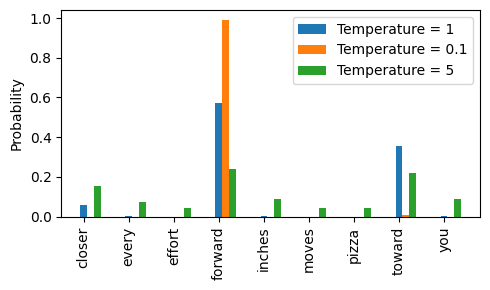

In [40]:
# Illustrate temperature through plotting
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize = (5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label = f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation = 90)
ax.legend()
plt.tight_layout()
plt.show()

## Exercise 5.1 - Page 155

In [41]:
# print the sampling frequencies of word pizza
def print_sampled_tokens_pizza(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples = 1).item() for i in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    print(f"{sampled_ids[6]} x {inverse_vocab[6]}")

for i in range(len(scaled_probas)):
    print(f"The scaled probas of word pizza when the temperature is {temperatures[i]}")
    print_sampled_tokens_pizza(scaled_probas[i])
print(f"The actual probability for word pizza is {scaled_probas[2][6]:.4f}")

The scaled probas of word pizza when the temperature is 1
0 x pizza
The scaled probas of word pizza when the temperature is 0.1
0 x pizza
The scaled probas of word pizza when the temperature is 5
43 x pizza
The actual probability for word pizza is 0.0430


## 5.3.2 Top-k sampling

In [42]:
# Implement top-k sampling
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [43]:
# Add mask to logits
new_logits = torch.where(condition = next_token_logits < top_logits[-1], input = torch.tensor(float('-inf')), other = next_token_logits)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [44]:
# Apply softmax to the masked logits
topk_probas = torch.softmax(new_logits, dim = 0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## 5.3.3 Modifying the text generation function

In [45]:
# A modified text generation function with more diversity
def generate(model, idx, max_new_tokens, context_size, temperature = 0.0, top_k = None, eos_id = None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)
        if temperature > 0.0:
            logits = logits / temperature
            logits = logits - logits.max(dim = -1, keepdim=True).values # numerical stability tip
            probs = torch.softmax(logits, dim = -1)
            idx_next = torch.multinomial(probs, num_samples = 1)
        else:
            idx_next = torch.argmax(logits, dim = -1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim = 1)
    return idx

In [46]:
# Test the new generate function
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("So far, I had", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 So far, I had courage to encounter to afterward long inconsistent with it was the sweep of despair.


## Exercise 5.2 - Page 158

In [47]:
# Play around with different temperatures and top-k settings
torch.manual_seed(123)
temperatures = [0.1, 10, 100]
top_ks = [5, 10, 20]
for temperature in temperatures:
    for k in top_ks:
        token_ids = generate(
            model=model,
            idx=text_to_token_ids("So far, I had", tokenizer),
            max_new_tokens=15,
            context_size=GPT_CONFIG_124M["context_length"],
            top_k=k,
            temperature=temperature
        )
        print(f"Current temperature: {temperature}, current k: {k}")
        print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Current temperature: 0.1, current k: 5
Output text:
 So far, I had read in every, with great effort to be. I had been long the
Current temperature: 0.1, current k: 10
Output text:
 So far, I had not at length, I felt that I could be. The whole thought was
Current temperature: 0.1, current k: 20
Output text:
 So far, I had not he to be in the hope of catching some faint ray of light.
Current temperature: 10, current k: 5
Output text:
 So far, I had not that it to see long agony; or twelve un of mind. I
Current temperature: 10, current k: 10
Output text:
 So far, I had become. The sentence for vault; is for that the ag this long—
Current temperature: 10, current k: 20
Output text:
 So far, I had no brainidden would and food as my dungeon no guess as some what have
Current temperature: 100, current k: 5
Output text:
 So far, I had counted in all, as my fancy for its no farther. The sentence—
Current temperature: 100, current k: 10
Output text:
 So far, I had to the prison as in every huma

## Exercise 5.3 - Page 159

In [48]:
# Force deterministic behavior
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("So far, I had", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=1,
    temperature=0
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 So far, I had not he to be in the hope of catching some faint ray of light. I proceeded for many paces; but still all


# 5.4 Loading and saving model weights in PyTorch

In [49]:
# Save the model
# torch.save(model.state_dict(), "model.pth")

In [50]:
# Load the model
# model = GPTModel(GPT_CONFIG_124M)
# model.load_state_dict(torch.load("model.pth", map_location = device))
# model.eval();

In [ ]:
# Save the model and optimizer together
# torch.save({"model_state_dict": model.state_dict(),
            # "optimizer_state_dict": optimizer.state_dict()}, "model_and_optimizer.pth")

In [ ]:
# Restore the model and optimizer states
# checkpoint = torch.load("model_and_optimizer.pth", map_location = device)
# model = GPTModel(GPT_CONFIG_124M)
# model.load_state_dict(checkpoint["model_state_dict"])
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
# optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# model.train();

## Exercise 5.4 - Page 160

In [53]:
# Continue pretraining after loading
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=1, eval_freq=5, eval_iter=5,
    start_context="So far, I had", tokenizer=tokenizer)

Epoch 1 (Step 000000): Train Loss 0.799, Val Loss 7.288
Epoch 1 (Step 000005): Train Loss 0.662, Val Loss 7.359
Epoch 1 (Step 000010): Train Loss 0.642, Val Loss 7.391
So far, I had not he who with that long agony; but no farther.  Nor had I erred in my calculations—nor had I endured in vain. I at length felt that I was free. The surcingle hung in ribands from my eyes


# Section 5.5 Loading pretrained weights from OpenAI
For section 5.5 and other exercises, please check the section-5-5-code.ipynb file.